# Wide ResNet Experiments

Рассмотрим модель Wide ResNet, которую от обычного ResNet отличает увеличенное число фильтров в конволлюционных блоках. Модель была предложена в статье https://arxiv.org/abs/1605.07146

Авторы исследовали множество моделей на основе классического ResNet, введя параметризацию (k, N), где k - фактор, увеличивающий ширину сети,  N - фактор, увеличивающий глубину.
![title](wide1.png)

Давайте убедимся, что увеличение ширины сети действительно позитивно сказывается на качестве и скорости обучения ResNet-а. Для этого обучим несколько сетей со сравнимым числом параметров  и разными конфигурациями глубины и ширины.

In [2]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
import sys

import numpy as np
import os
import blosc

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import os
import blosc
import pickle

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import tqdm_notebook as tqn
from tensorflow.contrib.layers import xavier_initializer_conv2d
from scipy.interpolate import spline
from collections import defaultdict

sys.path.append("..")
    
from dataset import DatasetIndex, Dataset
from dataset import Batch, action, model, inbatch_parallel
from wide_old import MnistBatch_old
from wide_old import draw_stats

In [4]:
def parameters_count(ppl):
    all_layers = ppl.get_model_by_name('resnet')[-1][-1].graph.get_collection('trainable_variables')
    n_parameters = 0
    for layer in all_layers:
        current_n = 1
        for dim_shape in (layer.get_shape().as_list()):
            current_n *= dim_shape
        n_parameters += current_n
    return (n_parameters)

### Загрузим данные MNIST:

In [ ]:
src = 'C:/Users/Dari/Documents/az_training/task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

### Создадим датасет для обучения и тестирования:

In [10]:
ix = DatasetIndex(range(58500))
train_dataset = Dataset(ix, MnistBatch_old)

test_ix = DatasetIndex(range(65000-58500))
test_dataset = Dataset(test_ix, MnistBatch_old)

In [ ]:
# test_losses_lengths = defaultdict(list)
# test_accs_lengths = defaultdict(list)
# train_times_lengths = defaultdict(list)
pipelines_dict_length  = defaultdict(list)

In [12]:
n_iterations = 400

In [12]:
# widening_factors = [2, 1]
# length_factors = [1, 1]
# add_blocks = [2, 8]
widening_factors = [2]
length_factors = [1]
add_blocks = [2]

In [13]:
for index, wid_factor in enumerate(widening_factors):
    config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'factor':wid_factor, \
                    'length_factor':length_factors[index], \
                    'add_blocks':add_blocks[index]}}
    stats = []
    loss_history = []
    time_list = []

    ppl = (train_dataset.pipeline(config=config)
                        .train_res(loss_history, stats, src[0][:58500], full_labs[:58500], time_list))

    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))

    print('current config', config['resnet']['factor'])


    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)

    print ('time ', np.mean(np.array(time_list)))

    test_losses_lengths[str(22) + '+' + str(index+1)] = current_loss
    test_accs_lengths[str(22) + '+' + str(index+1)] = current_acc
    train_times_lengths[str(22) + '+' + str(index+1)] = time_list

    pipelines_dict_length[str(22) + '+' + str(index+1)]  = ppl

current config 2


  0%|                                                                                          | 0/800 [00:00<?, ?it/s]

32 32
[None, 7, 7, 32]
[None, 7, 7, 32]
64 64
[None, 7, 7, 64]
[None, 7, 7, 64]
128 128
[None, 7, 7, 128]
[None, 7, 7, 128]
128 128
128 128


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [11:39<00:00,  1.14it/s]


time  0.382710287974


# First params

In [10]:
widening_factors = [3 ,2, 1]
length_factors = [1, 2, 8]
add_blocks = [0, 0, 0]

In [11]:
for index, wid_factor in enumerate(widening_factors):
    config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'factor':wid_factor, \
                    'length_factor':length_factors[index], \
                    'add_blocks':add_blocks[index]}}
    stats = []
    loss_history = []
    time_list = []

    ppl = (train_dataset.pipeline(config=config).
       train_res(loss_history, stats, src[0][:58500], full_labs[:58500], time_list))

    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))

    print('current config', config['resnet']['factor'])


    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)

    print ('time ', np.mean(np.array(time_list)))

    test_losses_lengths[str(index) + '+' + str(index)] = current_loss
    test_accs_lengths[str(index) + '+' + str(index)] = current_acc
    train_times_lengths[str(index) + '+' + str(index)] = time_list

    pipelines_dict_length[str(index) + '+' + str(index)]  = ppl

current config 3


  0%|                                                                                          | 0/800 [00:00<?, ?it/s]

48 48
[None, 7, 7, 48]
[None, 7, 7, 48]
96 96
[None, 7, 7, 96]
[None, 7, 7, 96]
192 192
[None, 7, 7, 192]
[None, 7, 7, 192]


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [08:33<00:00,  1.54it/s]


time  0.280135140519
current config 2


  0%|                                                                                          | 0/800 [00:00<?, ?it/s]

32 32
[None, 7, 7, 32]
[None, 7, 7, 32]
32 32
64 64
[None, 7, 7, 64]
[None, 7, 7, 64]
64 64
128 128
[None, 7, 7, 128]
[None, 7, 7, 128]
128 128


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [09:43<00:00,  1.38it/s]


time  0.322643945063
current config 1


  0%|                                                                                          | 0/800 [00:00<?, ?it/s]

16 16
[None, 7, 7, 16]
[None, 7, 7, 16]
16 16
16 16
16 16
16 16
16 16
16 16
16 16
32 32
[None, 7, 7, 32]
[None, 7, 7, 32]
32 32
32 32
32 32
32 32
32 32
32 32
32 32
64 64
[None, 7, 7, 64]
[None, 7, 7, 64]
64 64
64 64
64 64
64 64
64 64
64 64
64 64


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [14:48<00:00,  1.10s/it]


time  0.514526501518


# Результаты

Ниже представлены графики лоссов сетей с разной конфигурацией. Видно, что сеть самая широкая сеть (к=3, l = 8) обучается быстрее всего. 

Также можно заметить, что сеть с большим N, т.е. кратным увеличением блоков конволюций каждого размера работает заметно хуже чем, например, с добавлением 8 блоков в конец сети (т.е. увеличением числа конволюций с фильтрами большего размера). Т.е. увеличение числа конволюций с размером фильтра 16 * 16 оказывается не только бесполезным, но и вредным, замедляя время обучения. 

Однако это верно только для большого числа конволюций. Время обучения сети с двукратным увеличением числа одинаковых блоков (N=2) и расширение  (k=2) практически совпадает c добавлением 2 блоков в конец широкой сети (k=2, add=2)

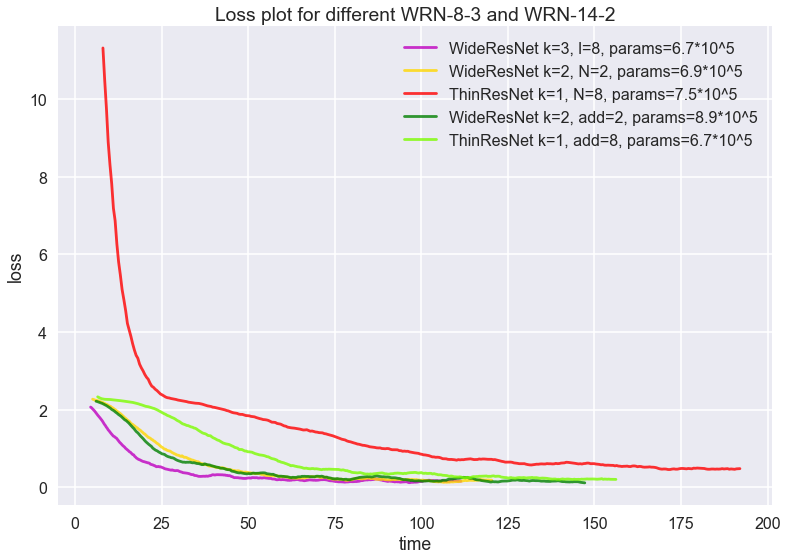

In [59]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different ResNet architectures')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue']
# keys_300 = ['0+0', '22+0', '22+1']
# keys_300 = ['22+1', '22+2']
keys_300 = ['0+0', '1+1', '2+2', '22+1', '22+2']
factors = ['WideResNet k=3, l=8, params=6.7*10^5', 'WideResNet k=2, N=2, params=6.9*10^5', 'ThinResNet k=1, N=8, params=7.5*10^5', 'WideResNet k=2, add=2, params=8.9*10^5', 'ThinResNet k=1, add=8, params=6.7*10^5']

for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_losses_lengths[current]
#     if index < 6 and index >0:
#         continue
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
    plt.plot(current_time[15:len(smoothed_current)], smoothed_current[15:], c=cols[index], label = factors[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

### Поэтому будет честнее сравнивать широкую сеть с не заведомо плохой глубокой "тонкой" сетью, а с той, глубина которой увеличена за счет добавления слоев в конец. 

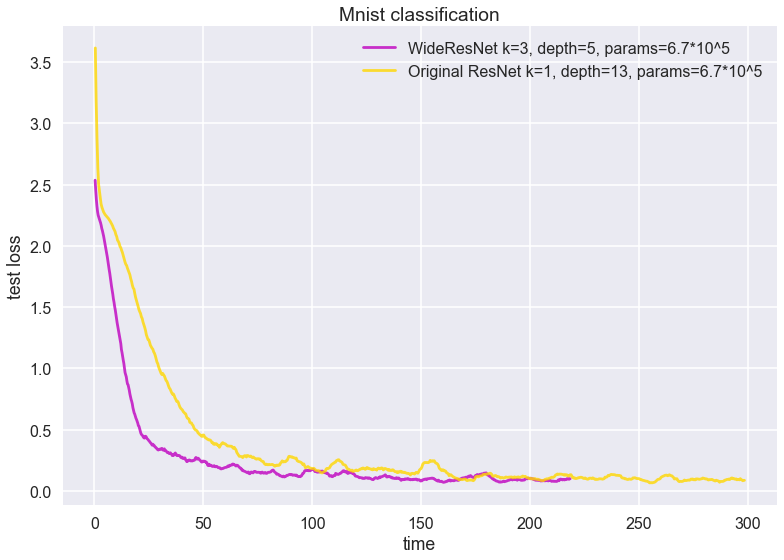

In [10]:
plt.style.use('seaborn-poster')
plt.title('Mnist classification')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue']
keys_300 = ['0+0', '22+1']
# keys_300 = ['22+0', '1+1']

factors = ['WideResNet k=3, depth=5, params=6.7*10^5', 'Original ResNet k=1, depth=13, params=6.7*10^5']
for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_losses_lengths[current]
#     if index < 6 and index >0:
#         continue
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
    plt.plot(current_time[0:len(smoothed_current)], smoothed_current[0:], c=cols[index], label = factors[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('test loss')
plt.show()

In [64]:
# parameters count 
for ppl_i in pipelines_dict_length.keys():
    print(ppl_i, ' ', parameters_count(pipelines_dict_length[ppl_i]))

22+1   894154
22+2   669178


# SAVE

In [26]:
with open("loss_results.txt", "wb") as a:
    pickle.dump(test_losses_lengths, a)
    
with open("accs_results.txt", "wb") as a:
    pickle.dump(test_accs_lengths, a)

with open("time_results.txt", "wb") as a:
    pickle.dump(train_times_lengths, a)

# LOAD

In [5]:
with open("loss_results.txt", "rb") as a:
    test_losses_lengths = pickle.load(a)
    
with open("accs_results.txt", "rb") as a:
    test_accs_lengths = pickle.load(a)

with open("time_results.txt", "rb") as a:
    train_times_lengths = pickle.load(a)
    
print('ok')

ok


#  NO MAXPULLING

In [7]:
from wide import MnistBatch

In [8]:
train_dataset = Dataset(ix, MnistBatch)
test_dataset = Dataset(test_ix, MnistBatch)

In [12]:
stats = []
loss_history = []
time_list = []
n_iterations = 400

config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                'factor':3, \
                'length_factor':1, \
                'add_blocks':0}}
    
ppl = (train_dataset.pipeline(config=config).
   train_res(loss_history, stats, src[0][:58500], full_labs[:58500], time_list))

current_loss = []
current_acc = []
test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))

print('current config', config['resnet']['factor'])


for i in tqdm(range(n_iterations)):
    ppl.next_batch(100, n_epochs=None, shuffle=2)
    test_ppl.next_batch(100, n_epochs=None, shuffle=2)

print ('time ', np.mean(np.array(time_list)))

current config 3


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

48 48
[None, 7, 7, 48]
[None, 7, 7, 48]
96 96
[None, 7, 7, 96]
[None, 7, 7, 96]
192 192
[None, 7, 7, 192]
[None, 7, 7, 192]


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [04:06<00:00,  1.66it/s]


time  0.263149847585


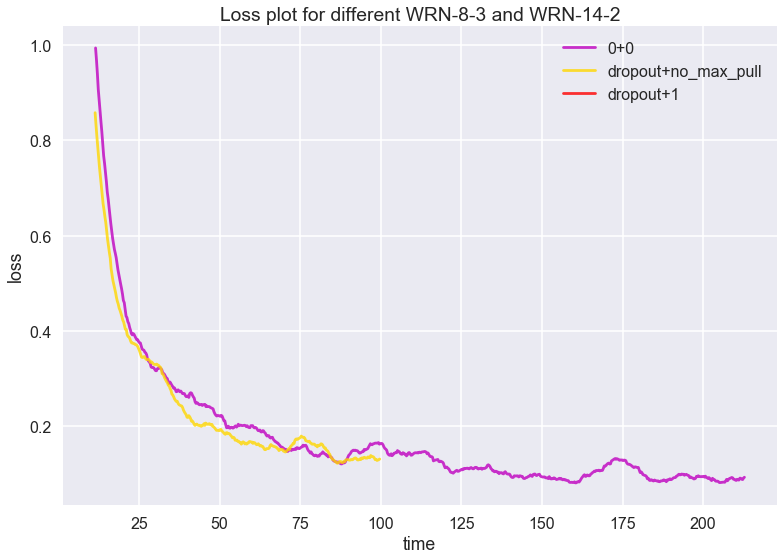

In [123]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different WRN-8-3 and WRN-14-2')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue']
# keys_300 = ['0+0', 'onlyMAX+0', 'dropout+no_max_pull', 'dropout+max_pull']
keys_300 = ['0+0',  'dropout+no_max_pull', 'dropout+1']
# , 'dropout+max_pull']

# keys_300 = ['22+1', '22+2']
# keys_300 = ['0+0', '44+0', 'no_mp+0', '1+1']
factors = ['WideResNet k=3, l=8, params=6.7*10^5', 'WideResNet k=2, N=2, params=6.9*10^5', 'ThinResNet k=1, N=8, params=7.5*10^5', 'WideResNet k=2, add=2, params=8.9*10^5', 'ThinResNet k=1, add=8, params=6.7*10^5']

for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_losses_lengths[current]
#     if index < 6 and index >0:x
#         continue
    smoothed_current = []
    for i in range(20, len(current_loss) - 20):
        smoothed_current.append(np.mean(current_loss[i-20:i+20]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
    plt.plot(current_time[40:len(smoothed_current)], smoothed_current[40:], c=cols[index], label = keys_300[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

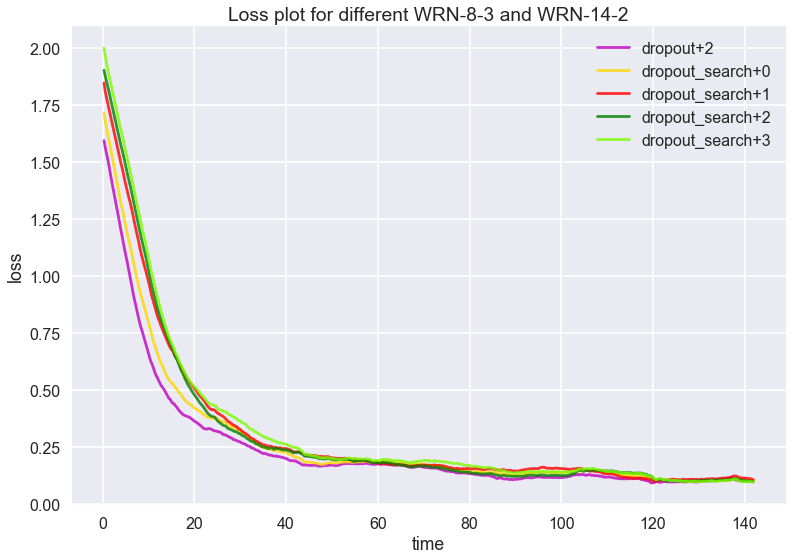

In [126]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different WRN-8-3 and WRN-14-2')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue']
# keys_300 = ['0+0', 'onlyMAX+0', 'dropout+no_max_pull', 'dropout+max_pull']
keys_300 = ['dropout+2', 'dropout_search+0', 'dropout_search+1', 'dropout_search+2', 'dropout_search+3']
# , 'dropout+max_pull']

# keys_300 = ['22+1', '22+2']
# keys_300 = ['0+0', '44+0', 'no_mp+0', '1+1']
factors = ['WideResNet k=3, l=8, params=6.7*10^5', 'WideResNet k=2, N=2, params=6.9*10^5', 'ThinResNet k=1, N=8, params=7.5*10^5', 'WideResNet k=2, add=2, params=8.9*10^5', 'ThinResNet k=1, add=8, params=6.7*10^5']

for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_losses_lengths[current]
#     if index < 6 and index >0:
#         continue
    smoothed_current = []
    for i in range(30, len(current_loss) - 30):
        smoothed_current.append(np.mean(current_loss[i-30:i+30]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
    
#     if index > 0:
#         plt.plot(current_time[-50:], smoothed_current[-50:], c=cols[index], label = keys_300[index], alpha=0.8)

    plt.plot(current_time[0:len(smoothed_current)], smoothed_current[0:], c=cols[index], label = keys_300[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

In [40]:
keys_300 = ['dropout+2', 'dropout_search+0', 'dropout_search+1', 'dropout_search+2', 'dropout_search+3']
for index, current in enumerate(keys_300):
    print(current, ' ', np.mean(np.array(test_accs_lengths[current][-30:])))
    
keys_300 = ['dropout+2', 'dropout_search_0+0', 'dropout_search_0+1', 'dropout_search_0+2', 'dropout_search_0+3']
for index, current in enumerate(keys_300):
    print(current, ' ', np.mean(np.array(test_accs_lengths[current][-30:])))



dropout+2   0.965667
dropout_search+0   0.969
dropout_search+1   0.964
dropout_search+2   0.973333
dropout_search+3   0.971333
dropout+2   0.965667
dropout_search_0+0   0.971333
dropout_search_0+1   0.969333
dropout_search_0+2   0.969
dropout_search_0+3   0.967


In [39]:
keys_300 = ['dropout+2', 'dropout_search+0', 'dropout_search+1', 'dropout_search+2', 'dropout_search+3']
for index, current in enumerate(keys_300):
    print(current, ' ', np.mean(np.array(test_accs_lengths[current][-100:])))
    
keys_300 = ['dropout+2', 'dropout_search_0+0', 'dropout_search_0+1', 'dropout_search_0+2', 'dropout_search_0+3']
for index, current in enumerate(keys_300):
    print(current, ' ', np.mean(np.array(test_accs_lengths[current][-100:])))



dropout+2   0.9662
dropout_search+0   0.9686
dropout_search+1   0.9648
dropout_search+2   0.9683
dropout_search+3   0.9689
dropout+2   0.9662
dropout_search_0+0   0.9682
dropout_search_0+1   0.9698
dropout_search_0+2   0.9661
dropout_search_0+3   0.9676


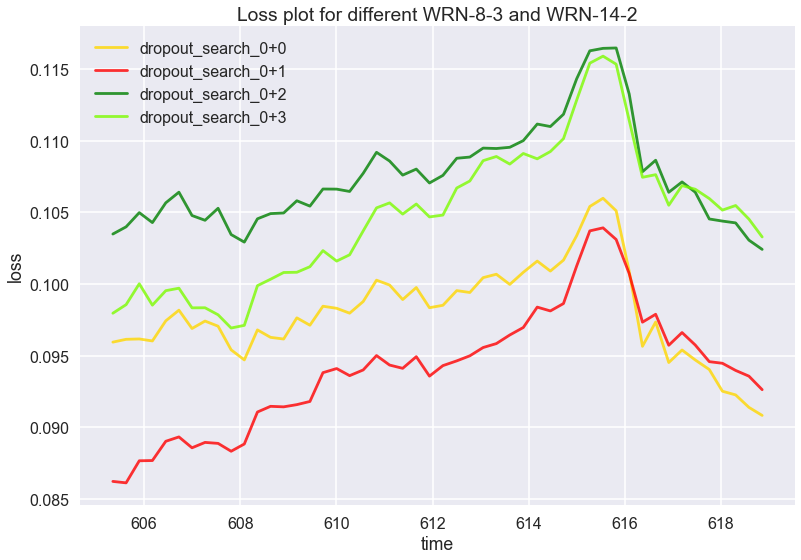

In [114]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different WRN-8-3 and WRN-14-2')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue']
# keys_300 = ['0+0', 'onlyMAX+0', 'dropout+no_max_pull', 'dropout+max_pull']
keys_300 = ['dropout+2', 'dropout_search_0+0', 'dropout_search_0+1', 'dropout_search_0+2', 'dropout_search_0+3']
# , 'dropout+max_pull']

# keys_300 = ['22+1', '22+2']
# keys_300 = ['0+0', '44+0', 'no_mp+0', '1+1']
factors = ['WideResNet k=3, l=8, params=6.7*10^5', 'WideResNet k=2, N=2, params=6.9*10^5', 'ThinResNet k=1, N=8, params=7.5*10^5', 'WideResNet k=2, add=2, params=8.9*10^5', 'ThinResNet k=1, add=8, params=6.7*10^5']

for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_losses_lengths[current]
#     if index < 6 and index >0:
#         continue
    smoothed_current = []
    for i in range(30, len(current_loss) - 30):
        smoothed_current.append(np.mean(current_loss[i-30:i+30]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
#     plt.plot(current_time[40:len(smoothed_current)], smoothed_current[40:], c=cols[index], label = keys_300[index], alpha=0.8)
    if index > 0:
        plt.plot(current_time[-50:], smoothed_current[-50:], c=cols[index], label = keys_300[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

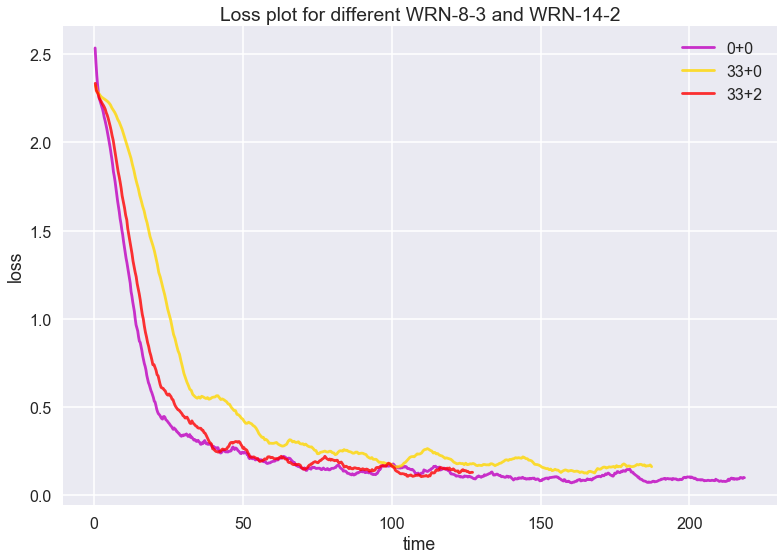

In [11]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different WRN-8-3 and WRN-14-2')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue']
keys_300 = ['0+0', '33+0', '33+2']
# keys_300 = ['22+1', '22+2']
# keys_300 = ['0+0', '44+0', 'no_mp+0', '1+1']
factors = ['WideResNet k=3, l=8, params=6.7*10^5', 'WideResNet k=2, N=2, params=6.9*10^5', 'ThinResNet k=1, N=8, params=7.5*10^5', 'WideResNet k=2, add=2, params=8.9*10^5', 'ThinResNet k=1, add=8, params=6.7*10^5']

for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_losses_lengths[current]
#     if index < 6 and index >0:
#         continue
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
    plt.plot(current_time[0:len(smoothed_current)], smoothed_current[0:], c=cols[index], label = keys_300[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

# DROPOUT

In [14]:
from myBatchWide import MnistBatch_new

In [94]:
train_dataset = Dataset(ix, MnistBatch_new)
test_dataset = Dataset(test_ix, MnistBatch_new)

In [22]:
stats = []
loss_history = []
time_list = []
n_iterations = 550
rates = [0.1, 0.2, 0.3, 0.4]
config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                'factor':3, \
                'length_factor':1, \
                'add_blocks':0}}

for index in range(len(rates)):
    
    ppl = (train_dataset.pipeline(config=config) 
                        .train_res(loss_history, stats, src[0][:58500], full_labs[:58500], time_list, rates[index]))

    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], \
                                                                        full_labs[58500:], rates[index]))

    print('current config', config['resnet']['factor'])

    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)

    print ('time ', np.mean(np.array(time_list)))
    test_losses_lengths['dropout_search_0' + '+' + str(index)] = current_loss
    test_accs_lengths['dropout_search_0' + '+' + str(index)] = current_acc
    train_times_lengths['dropout_search_0' + '+' + str(index)] = time_list

    pipelines_dict_length['dropout_search_0' + '+' + str(index)]  = ppl

current config 3


  0%|                                                                                          | 0/550 [00:00<?, ?it/s]

48 48
[None, 7, 7, 48]
[None, 7, 7, 48]
96 96
[None, 7, 7, 96]
[None, 7, 7, 96]
192 192
[None, 7, 7, 192]
[None, 7, 7, 192]


100%|████████████████████████████████████████████████████████████████████████████████| 550/550 [05:49<00:00,  1.57it/s]


time  0.278679425886
current config 3


  0%|                                                                                          | 0/550 [00:00<?, ?it/s]

48 48
[None, 7, 7, 48]
[None, 7, 7, 48]
96 96
[None, 7, 7, 96]
[None, 7, 7, 96]
192 192
[None, 7, 7, 192]
[None, 7, 7, 192]


100%|████████████████████████████████████████████████████████████████████████████████| 550/550 [05:49<00:00,  1.59it/s]


time  0.278581106104
current config 3


  0%|                                                                                          | 0/550 [00:00<?, ?it/s]

48 48
[None, 7, 7, 48]
[None, 7, 7, 48]
96 96
[None, 7, 7, 96]
[None, 7, 7, 96]
192 192
[None, 7, 7, 192]
[None, 7, 7, 192]


100%|████████████████████████████████████████████████████████████████████████████████| 550/550 [05:51<00:00,  1.58it/s]


time  0.278955878368
current config 3


  0%|                                                                                          | 0/550 [00:00<?, ?it/s]

48 48
[None, 7, 7, 48]
[None, 7, 7, 48]
96 96
[None, 7, 7, 96]
[None, 7, 7, 96]
192 192
[None, 7, 7, 192]
[None, 7, 7, 192]


100%|████████████████████████████████████████████████████████████████████████████████| 550/550 [05:49<00:00,  1.58it/s]


time  0.278785304648


In [231]:
stats = []
loss_history = []
time_list = []
n_iterations = 550
rates = [0.2]
config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                'factor':3, \
                'length_factor':1, \
                'add_blocks':0}}

for index in range(len(rates)):
    
    ppl = (train_dataset.pipeline(config=config) 
                        .train_res(loss_history, stats, src[0][:58500], full_labs[:58500], time_list, rates[index]))

    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], \
                                                                        full_labs[58500:], rates[index]))

    print('current config', config['resnet']['factor'])

    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)

    print ('time ', np.mean(np.array(time_list)))
    test_losses_lengths['dropout_search_0_copy' + '+' + str(1)] = current_loss
    test_accs_lengths['dropout_search_0_copy' + '+' + str(1)] = current_acc
    train_times_lengths['dropout_search_0_copy' + '+' + str(1)] = time_list

    pipelines_dict_length['dropout_search_0_copy' + '+' + str(1)]  = ppl

current config 3


  0%|                                                                                          | 0/550 [00:00<?, ?it/s]

48 48
[None, 7, 7, 48]
[None, 7, 7, 48]
96 96
[None, 7, 7, 96]
[None, 7, 7, 96]
192 192
[None, 7, 7, 192]
[None, 7, 7, 192]


100%|████████████████████████████████████████████████████████████████████████████████| 550/550 [05:54<00:00,  1.57it/s]


time  0.284113965454


In [38]:
pipelines_dict_length.keys()

dict_keys(['dropout+2', 'dropout_search+0', 'dropout_search+1', 'dropout_search+2', 'dropout_search+3', 'dropout_search_0+0', 'dropout_search_0+1', 'dropout_search_0+2', 'dropout_search_0+3'])

In [51]:
n_iterations = 100
rates = [0.1, 0.2, 0.3, 0.4]
keys = ['dropout+2']

# test_losses = defaultdict(list)
# test_accs = defaultdict(list)

for index, current_key in enumerate(keys):
    ppl = pipelines_dict_length[current_key]
    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl)
                              .update_stats(current_loss, current_acc, src[0][58500:], \
                                                                        full_labs[58500:], rates[index % 4]))
    for i in tqdm(range(n_iterations)):
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)
    
    test_losses[current_key] = current_loss
    test_accs[current_key] = current_acc


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.46it/s]


In [41]:
n_iterations = 100
rates = [0.1, 0.2, 0.3, 0.4]
keys = ['dropout_search+0', 'dropout_search+1', 'dropout_search+2', 'dropout_search+3', \
        'dropout_search_0+0', 'dropout_search_0+1', 'dropout_search_0+2', 'dropout_search_0+3']

test_losses = defaultdict(list)
test_accs = defaultdict(list)

for index, current_key in enumerate(keys):
    ppl = pipelines_dict_length[current_key]
    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl)
                              .update_stats(current_loss, current_acc, src[0][58500:], \
                                                                        full_labs[58500:], rates[index % 4]))
    for i in tqdm(range(n_iterations)):
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)
    
    test_losses[current_key] = current_loss
    test_accs[current_key] = current_acc


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.37it/s]


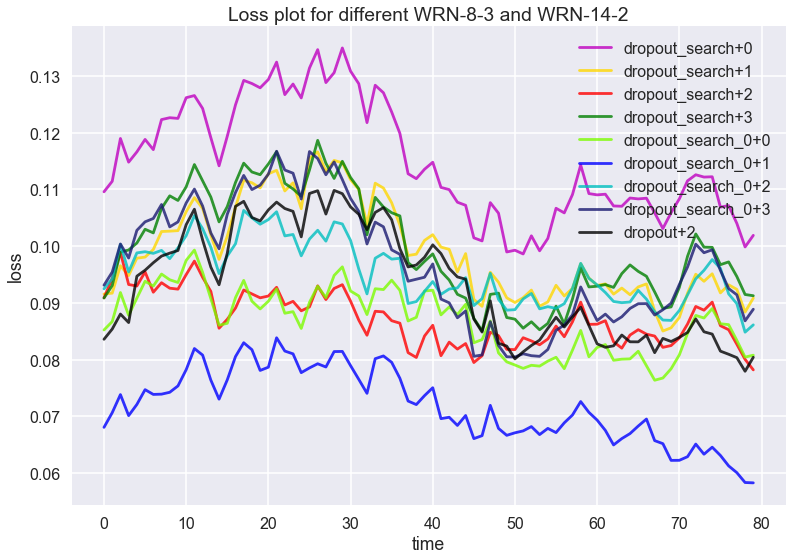

In [54]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different WRN-8-3 and WRN-14-2')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue', 'black']
# keys_300 = ['0+0', 'onlyMAX+0', 'dropout+no_max_pull', 'dropout+max_pull']
keys = ['dropout_search+0', 'dropout_search+1', 'dropout_search+2', 'dropout_search+3', \
        'dropout_search_0+0', 'dropout_search_0+1', 'dropout_search_0+2', 'dropout_search_0+3', 'dropout+2']
# , 'dropout+max_pull']

# keys_300 = ['22+1', '22+2']
# keys_300 = ['0+0', '44+0', 'no_mp+0', '1+1']
factors = ['WideResNet k=3, l=8, params=6.7*10^5', 'WideResNet k=2, N=2, params=6.9*10^5', 'ThinResNet k=1, N=8, params=7.5*10^5', 'WideResNet k=2, add=2, params=8.9*10^5', 'ThinResNet k=1, add=8, params=6.7*10^5']

for index, current in enumerate(keys):
#     current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_losses[current]
#     if index < 6 and index >0:
#         continue
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
    plt.plot(smoothed_current[:], c=cols[index], label = keys[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

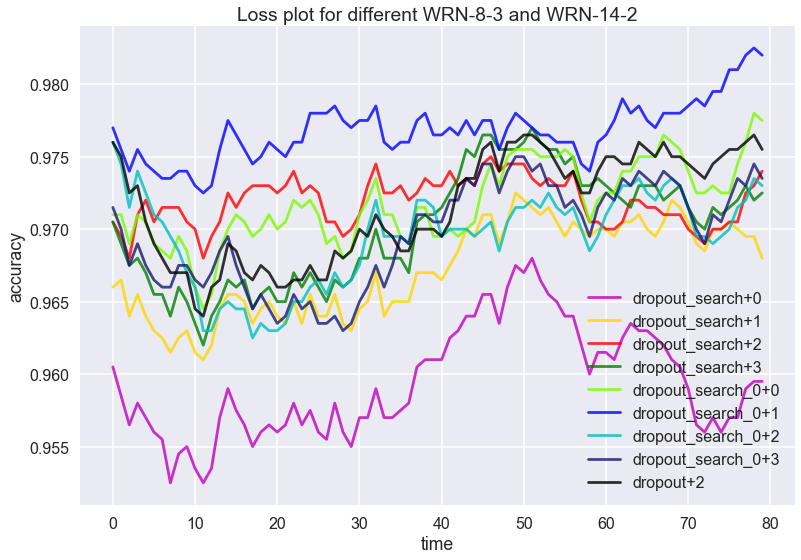

In [57]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different WRN-8-3 and WRN-14-2')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue', 'black']
# keys_300 = ['0+0', 'onlyMAX+0', 'dropout+no_max_pull', 'dropout+max_pull']
keys = ['dropout_search+0', 'dropout_search+1', 'dropout_search+2', 'dropout_search+3', \
        'dropout_search_0+0', 'dropout_search_0+1', 'dropout_search_0+2', 'dropout_search_0+3', 'dropout+2']
# , 'dropout+max_pull']

# keys_300 = ['22+1', '22+2']
# keys_300 = ['0+0', '44+0', 'no_mp+0', '1+1']
factors = ['WideResNet k=3, l=8, params=6.7*10^5', 'WideResNet k=2, N=2, params=6.9*10^5', 'ThinResNet k=1, N=8, params=7.5*10^5', 'WideResNet k=2, add=2, params=8.9*10^5', 'ThinResNet k=1, add=8, params=6.7*10^5']

for index, current in enumerate(keys):
#     current_time = np.cumsum(train_times_lengths[current])
    current_accs = test_accs[current]
#     if index < 6 and index >0:
#         continue
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_accs[i-10:i+10]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
    plt.plot(smoothed_current[:], c=cols[index], label = keys[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('accuracy')
plt.show()

In [61]:
for index, current in enumerate(keys):
    print(current, ' ', np.mean(np.array(test_accs[current])))

dropout_search+0   0.9596
dropout_search+1   0.967
dropout_search+2   0.972
dropout_search+3   0.9704
dropout_search_0+0   0.972
dropout_search_0+1   0.9774
dropout_search_0+2   0.9705
dropout_search_0+3   0.9702
dropout+2   0.9722


In [77]:
for ind in test_losses:
    print(len(ind))

16
16
16
16
18
18
18
18
9


# Weights distribution

In [240]:
additionally_saved_initial_weights = weights.copy()
additionally_saved_biases = biases.copy()

In [313]:
old_ppl = pipelines_dict_length['dropout+2']
old_sess = old_ppl.get_model_by_name("resnet")[-2][-1]
old_graph = old_sess.graph
old_weights, old_biases = [], []
old_variables = old_graph.get_collection('trainable_variables')
old_weights.append(old_sess.run(old_variables[::2]))
old_biases.append(old_sess.run(old_variables[1::2]))
saved_weights['old'] = old_weights
saved_biases['old'] = old_biases

In [234]:
saved_weights = defaultdict()
saved_biases = defaultdict()

In [235]:
new_ppl = pipelines_dict_length['dropout_search_0_copy+1'] 
sess = new_ppl.get_model_by_name("resnet")[-2][-1]
graph = sess.graph

In [237]:
weights, biases = [], []
variables = graph.get_collection('trainable_variables')
weights.append(sess.run(variables[::2]))
biases.append(sess.run(variables[1::2]))

saved_weights['0'] = weights
saved_biases['0'] = biases

In [238]:
len(variables)

22

In [241]:
weights = np.array(weights[0])
biases = np.array(biases[0])
percentage = []
accuracy = []

In [227]:
current_weights = weights.copy()

In [242]:
index = 0
for const in tqn(np.linspace(1e-2, 9e-2)):
    zeros_on_layer = []
    index += 1
    current_weights = weights.copy()
    current_biases = biases.copy()
    for i in range(len(weights)):
        weight_ind = np.where(np.abs(weights[i]) < const)
        zeros_on_layer.append(len(weight_ind[0]) / np.array(weights[i].shape).prod())
        current_weights[i][weight_ind] = 0
        current_biases[i][np.where(np.abs(biases[i]) < const)] = 0
    percentage.append(zeros_on_layer)
    
    assign = []
    for i in range(0, 22, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[i], current_weights[i//2]))
    for i in range(1, 22, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[i], current_biases[i//2]))
    sess.run(assign)
#     train_dataset.reset_iter()
#     pipelines_dict_length['dropout_search_0+1'].next_batch(50, shuffle=True)
    
    loss = []
    acc =[]
    test_ppl = (test_dataset.p.import_model('resnet', new_ppl)
                          .update_stats(loss, acc, src[0][58500:], \
                                                                    full_labs[58500:], 0.2))
    test_ppl.next_batch(100, shuffle=True)
    accuracy.append(acc)
    
    saved_weights[str(index)] = current_weights
    saved_biases[str(index)] = current_biases

In [133]:
print(np.array(percentage).shape)
print(len(accuracy))


(50, 11)
50


In [243]:
a = np.linspace(1e-2,9e-2)

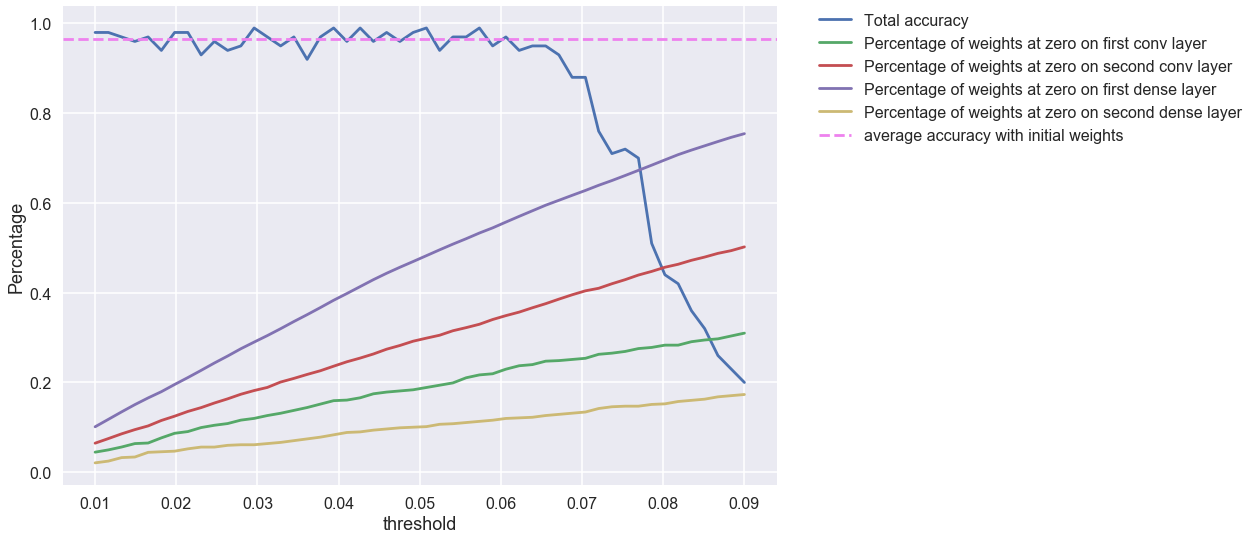

In [244]:
plt.xlabel('threshold', fontsize=18)
plt.ylabel('Percentage', fontsize=18)
plt.plot(a, accuracy, label='Total accuracy')
plt.plot( a,np.array(percentage)[:,0], label='Percentage of weights at zero on first conv layer')
plt.plot( a,np.array(percentage)[:,1], label='Percentage of weights at zero on second conv layer')
plt.plot( a,np.array(percentage)[:,2], label='Percentage of weights at zero on third conv layer')
plt.plot( a,np.array(percentage)[:,3], label='Percentage of weights at zero on fourth conv layer')
plt.axhline(y= np.mean(np.array(test_accs_lengths['dropout_search_0_copy+1'][-10:])), c='violet', \
            label='average accuracy with initial weights ', linestyle='--')
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
index = 0
for const in tqn(np.linspace(1e-2, 9e-2)):
    zeros_on_layer = []
    index += 1
    current_weights = weights.copy()
    current_biases = biases.copy()
    for i in range(len(weights)):
        weight_ind = np.where(np.abs(weights[i]) < const)
        zeros_on_layer.append(len(weight_ind[0]) / np.array(weights[i].shape).prod())
        current_weights[i][weight_ind] = 0
        current_biases[i][np.where(np.abs(biases[i]) < const)] = 0
    percentage.append(zeros_on_layer)
    
    assign = []
    for i in range(0, 22, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[i], current_weights[i//2]))
    for i in range(1, 22, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[i], current_biases[i//2]))
    sess.run(assign)
#     train_dataset.reset_iter()
#     pipelines_dict_length['dropout_search_0+1'].next_batch(50, shuffle=True)
    
    loss = []
    acc =[]
    test_ppl = (test_dataset.p.import_model('resnet', new_ppl)
                          .update_stats(loss, acc, src[0][58500:], \
                                                                    full_labs[58500:], 0.2))
    test_ppl.next_batch(100, shuffle=True)
    accuracy.append(acc)
    
    saved_weights[str(index)] = current_weights
    saved_biases[str(index)] = current_biases

In [310]:
accuracy[40]

[0.72000003]

In [309]:
keys = list(range(0, 35, 10)) + [35]
print(keys)

[0, 10, 20, 30, 35]


In [ ]:
list_keys = ['old', 0, ]

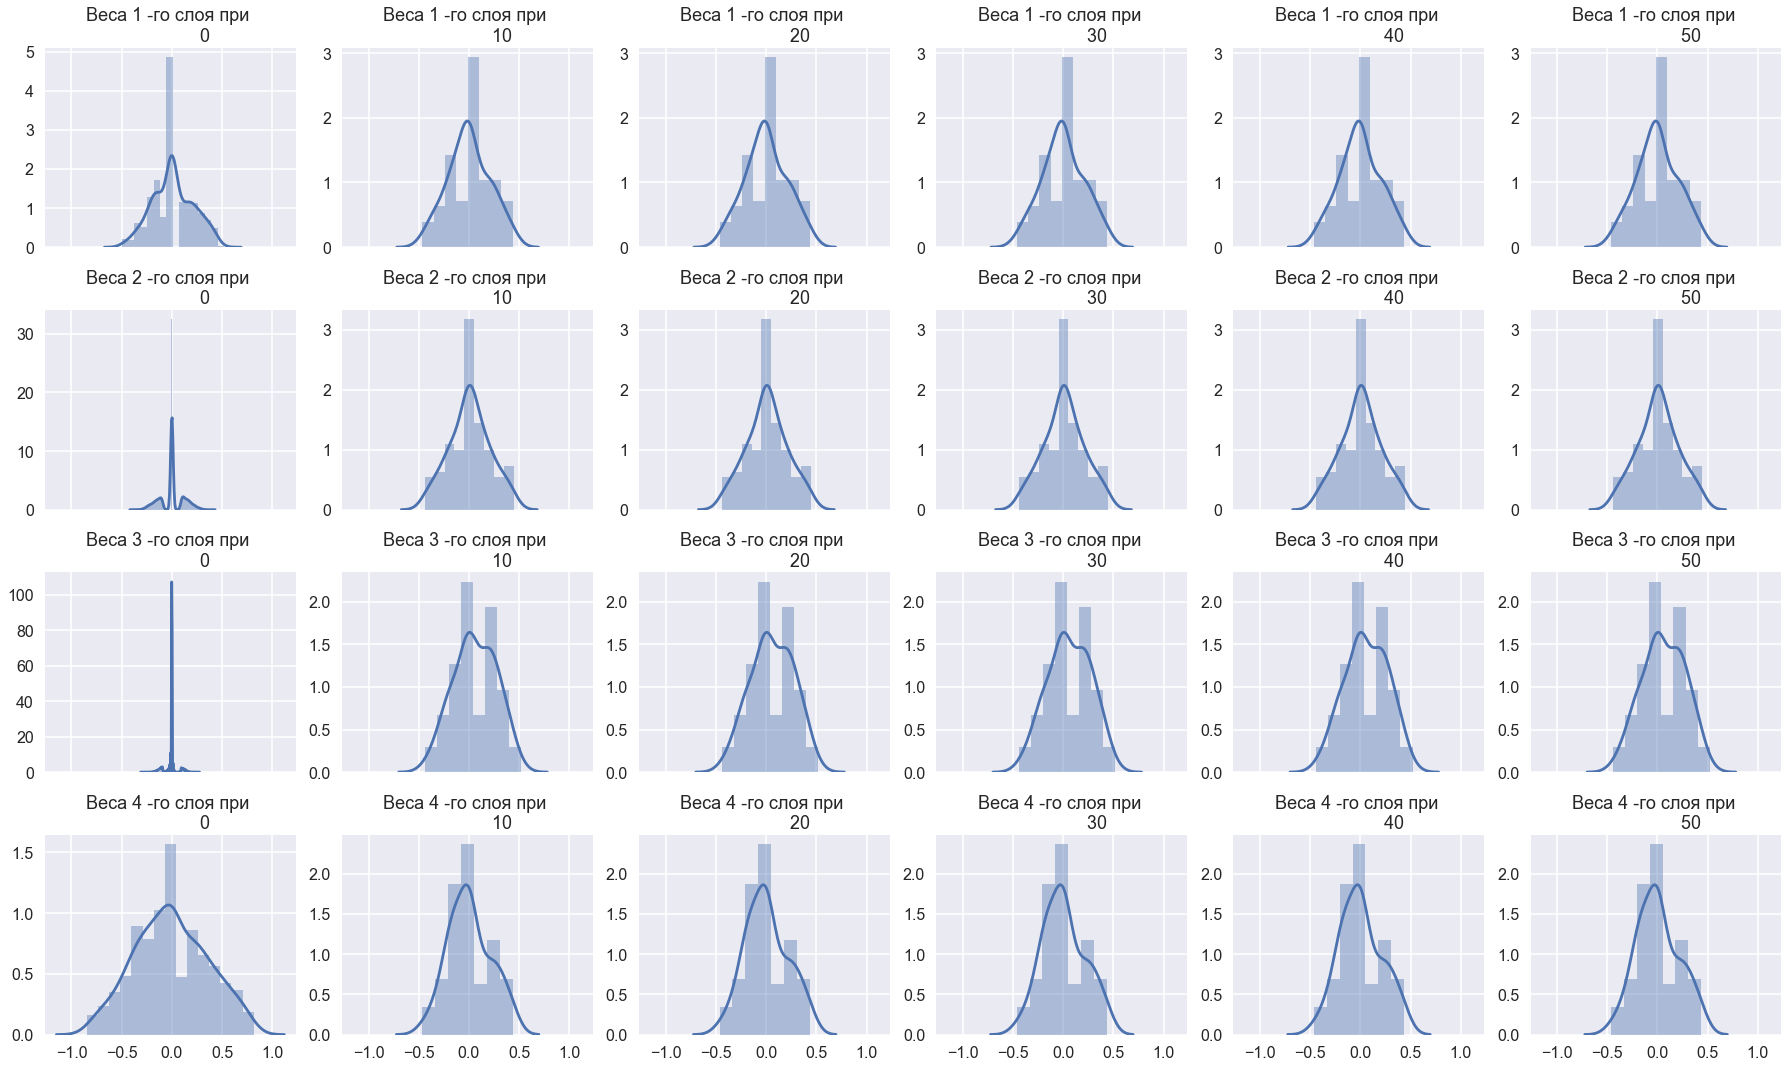

In [314]:
fig, axes = plt.subplots(nrows=4, ncols=6, sharex=True, sharey=False, figsize=(25, 15))

for i in range(0, 52, 10):
    for j, layer in enumerate(saved_weights[str(i)][0]):
        if j > 3:
            break
        axes[j, i // 10].set_title('Веса {} -го слоя при \n \
             {}'.format(j+1, i), fontsize=18)
        current = (np.reshape(layer, -1))
        sns.distplot(current,  ax=axes[j, i // 10])

plt.tight_layout()
plt.show()

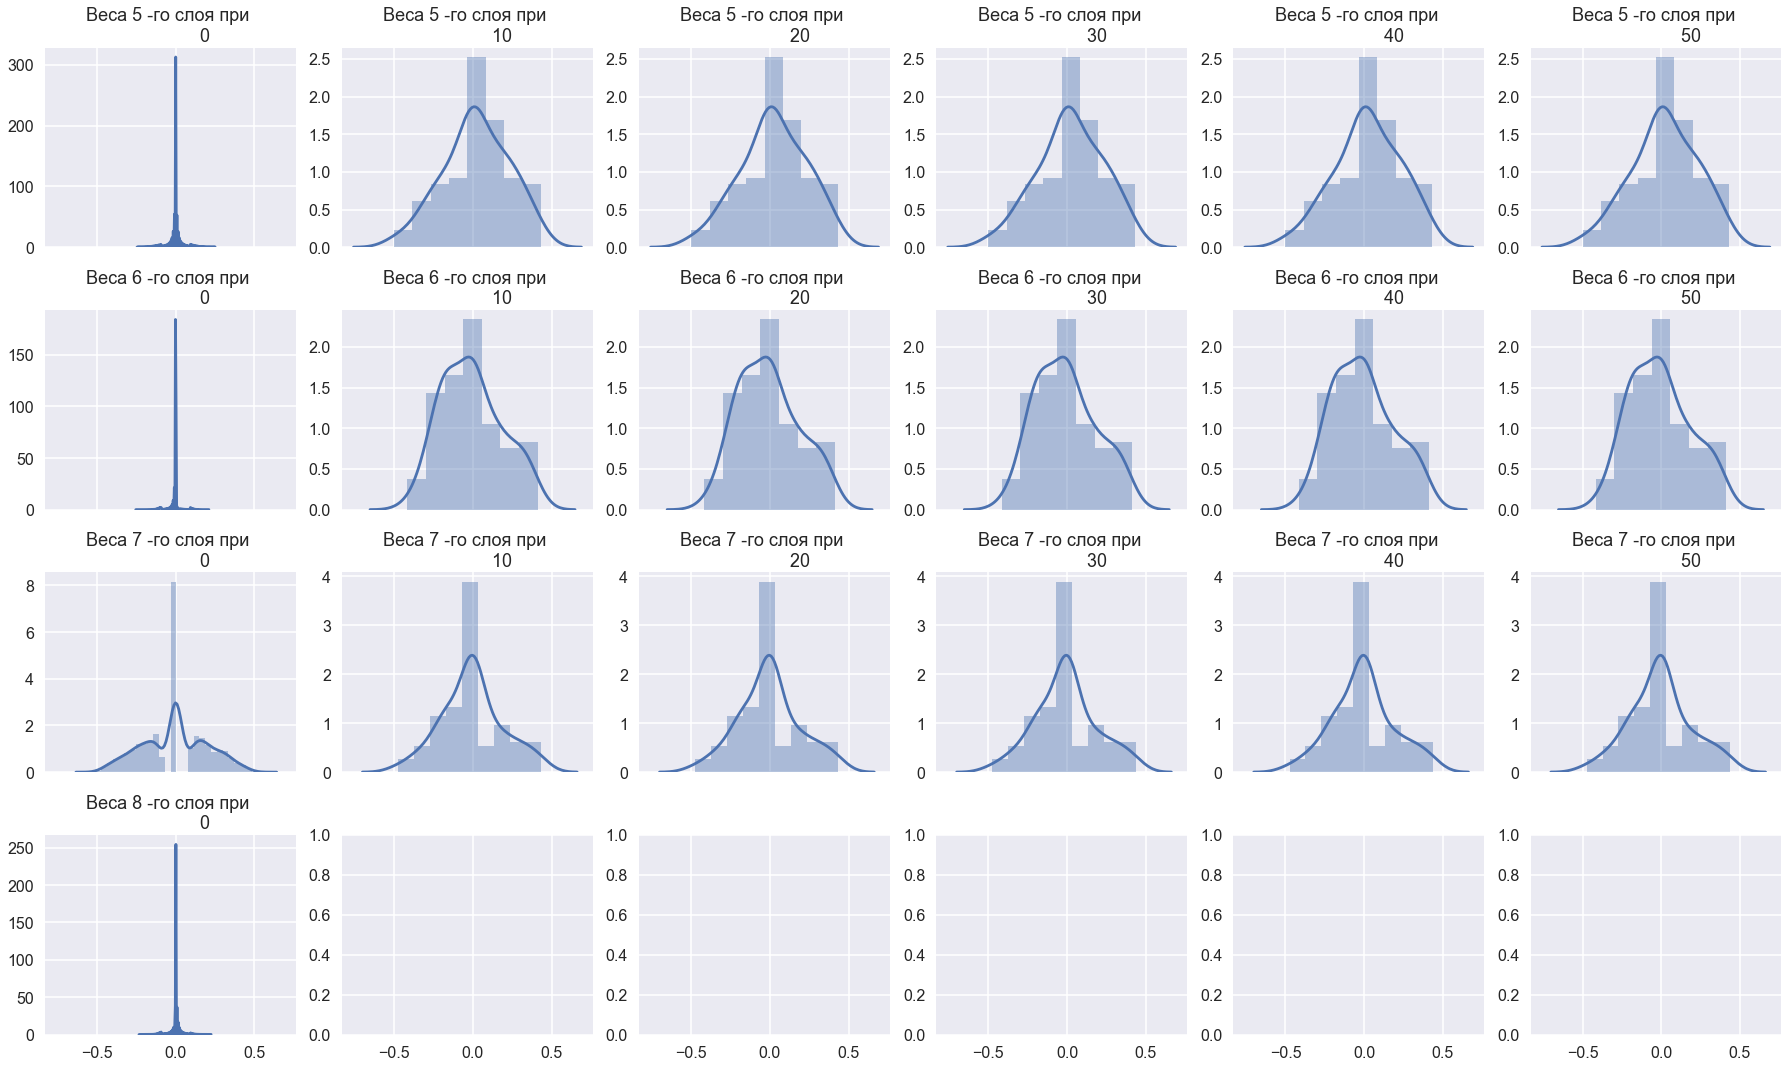

In [315]:
fig, axes = plt.subplots(nrows=4, ncols=6, sharex=True, sharey=False, figsize=(25, 15))

for i in range(0, 52, 10):
    
    for j, layer in enumerate(saved_weights[str(i)][0]):
        if j < 4 or j > 7:
            continue
        axes[j % 4, i // 10].set_title('Веса {} -го слоя при \n \
             {}'.format(j+1, i), fontsize=18)
        current = (np.reshape(layer, -1))
        sns.distplot(current,  ax=axes[j % 4, i // 10])

plt.tight_layout()
plt.show()

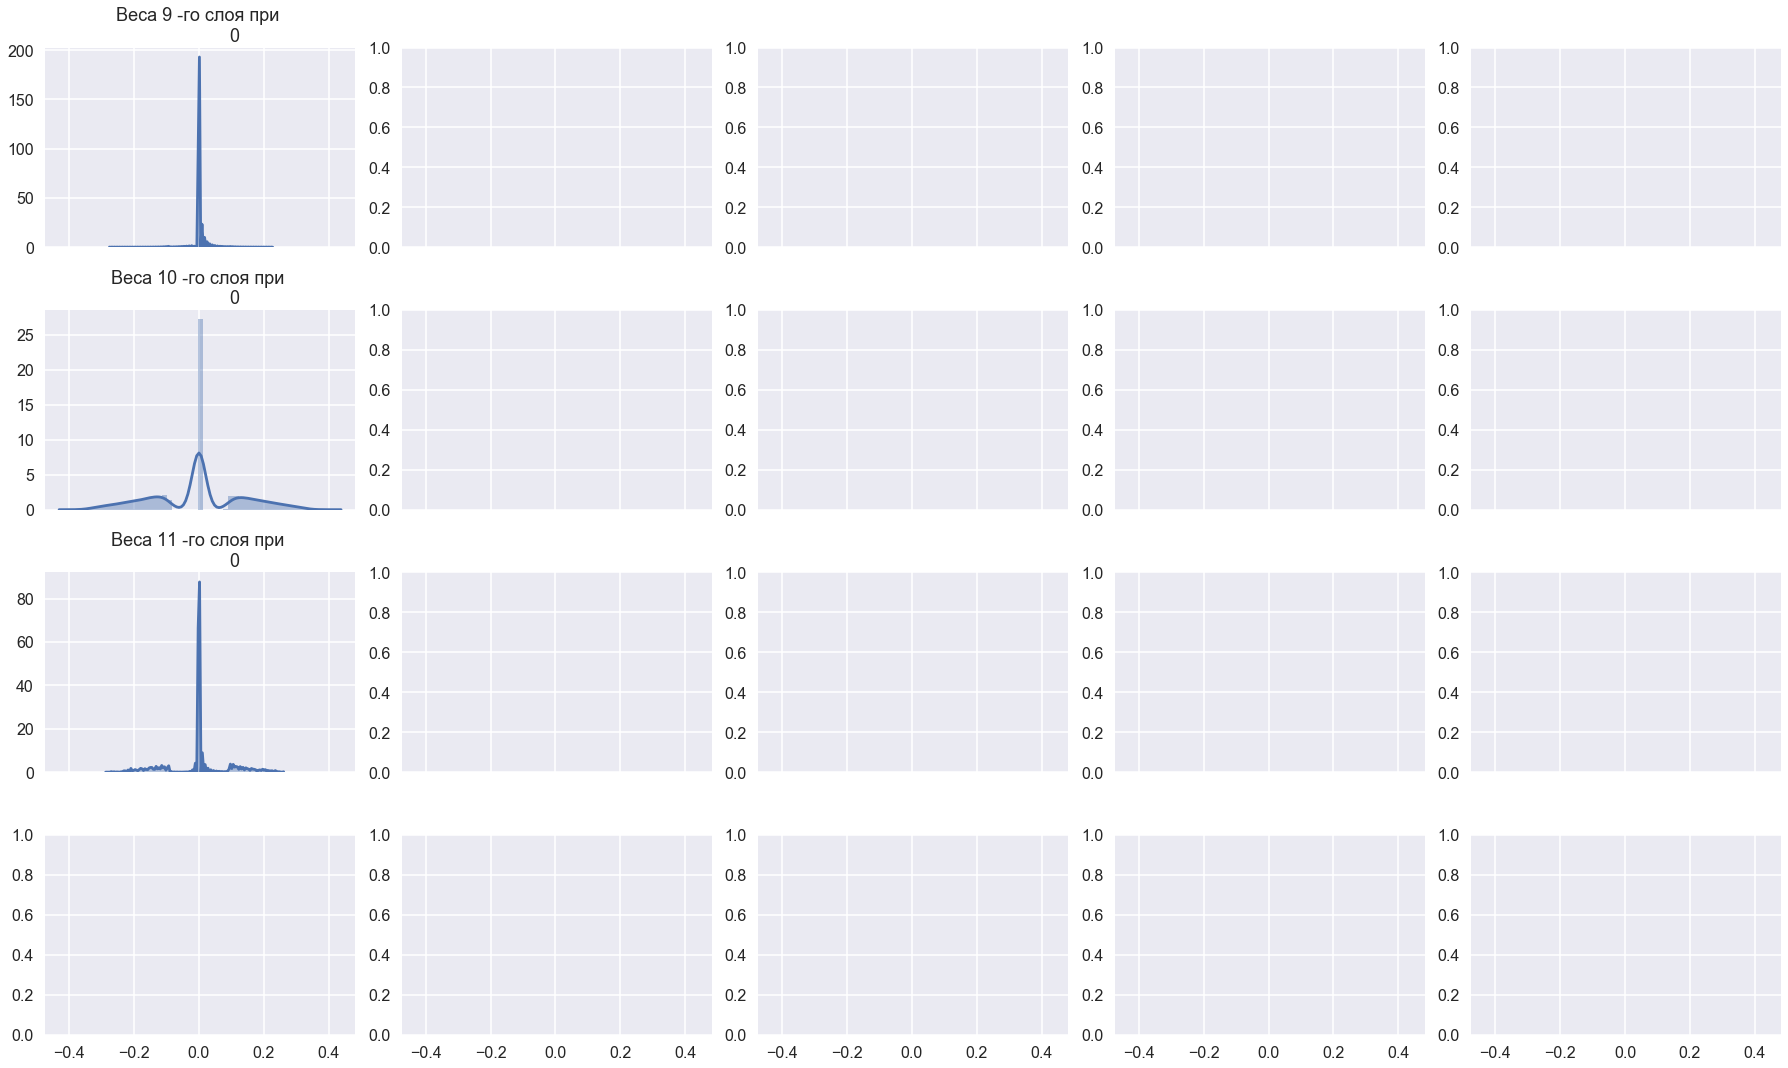

In [263]:
fig, axes = plt.subplots(nrows=4, ncols=5, sharex=True, sharey=False, figsize=(25, 15))

for i in range(0, 42, 10):
    
    for j, layer in enumerate(saved_weights[str(i)][0]):
        if j < 8:
            continue
        axes[j % 4, i // 10].set_title('Веса {} -го слоя при \n \
             {}'.format(j+1, i), fontsize=18)
        current = (np.reshape(layer, -1))
        sns.distplot(current,  ax=axes[j % 4, i // 10])

plt.tight_layout()
plt.show()

C:\Users\Dari\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\Dari\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


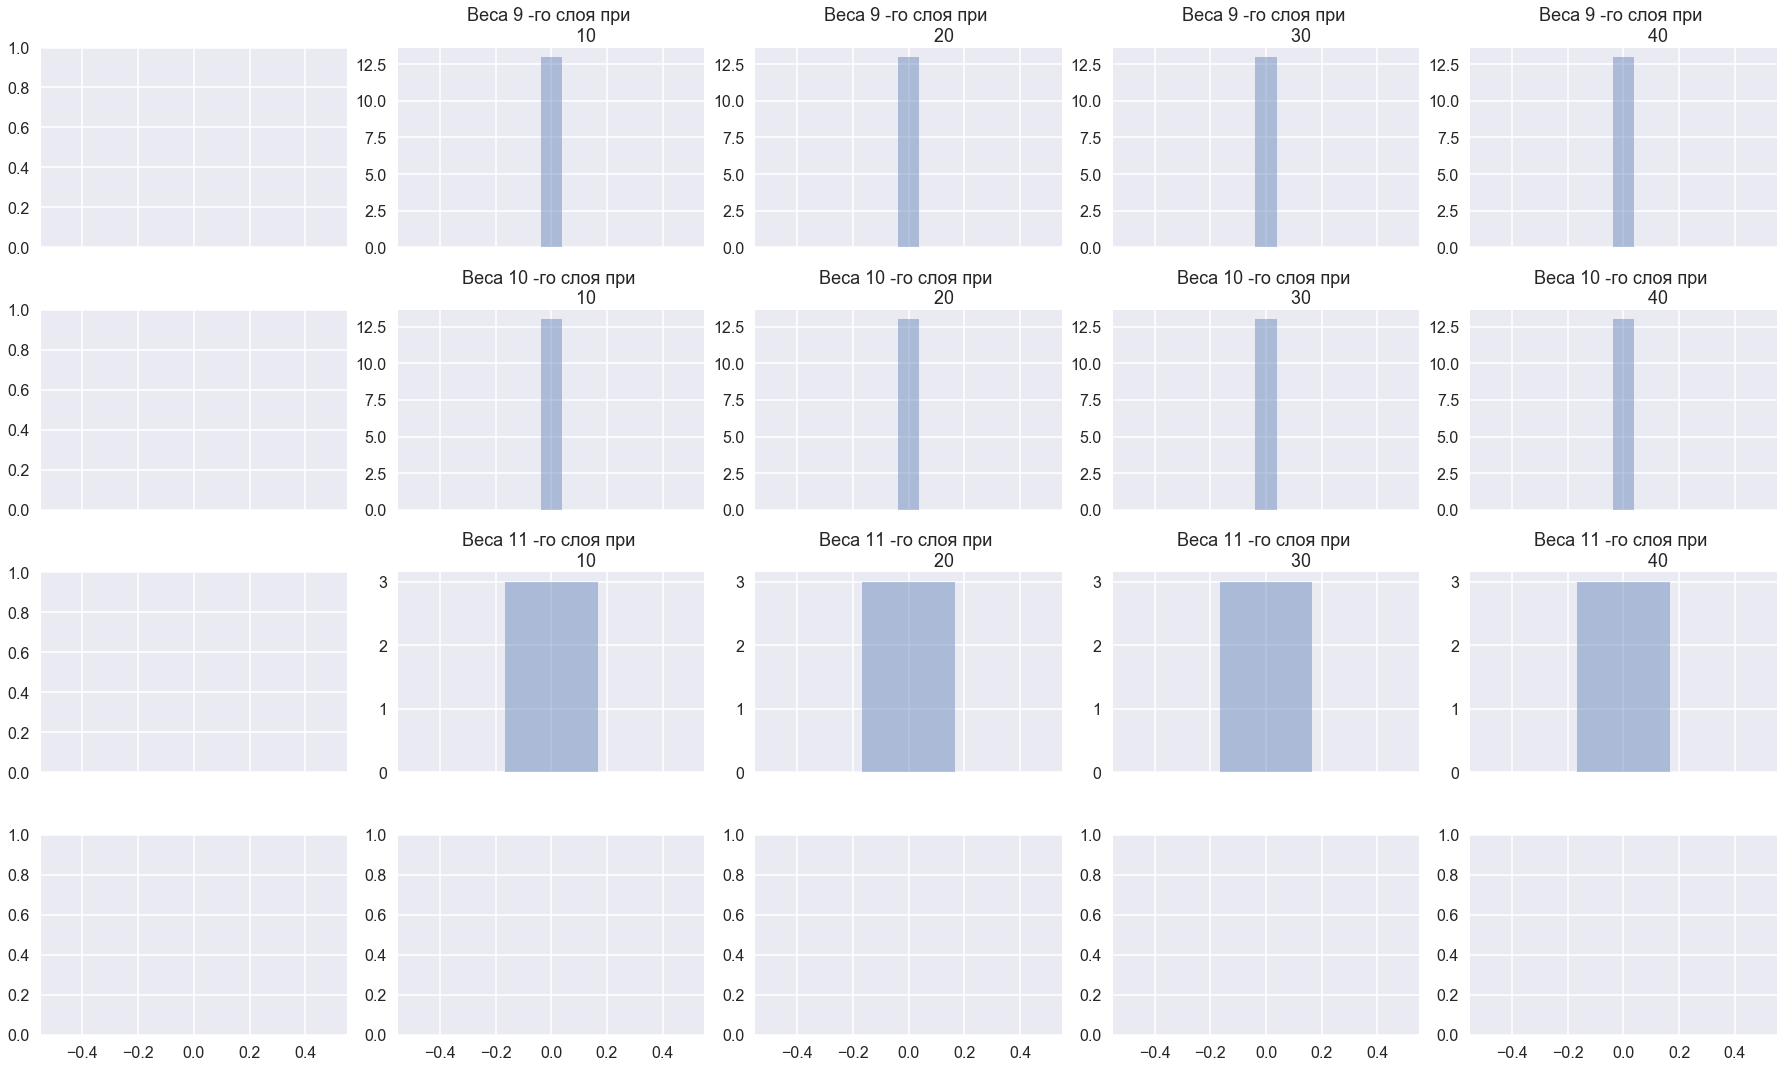

In [320]:
fig, axes = plt.subplots(nrows=4, ncols=5, sharex=True, sharey=False, figsize=(25, 15))

for i in range(0, 42, 10):
    
    for j, layer in enumerate(saved_biases[str(i)]):
        if j < 8:
            continue
        axes[j % 4, i // 10].set_title('Веса {} -го слоя при \n \
             {}'.format(j+1, i), fontsize=18)
        current = (np.reshape(layer, -1))
        sns.distplot(current,  ax=axes[j % 4, i // 10])
        
plt.tight_layout()
plt.show()

In [325]:
saved_weights['35']

array([ array([[[[ 0.        ,  0.33142361,  0.18631054, -0.39539117, -0.36972928,
          -0.13287243, -0.12998436,  0.        , -0.11379162,  0.        ,
           0.        , -0.11184476,  0.        ,  0.        ,  0.17132995,
           0.18716124]],

        [[ 0.30842748,  0.        ,  0.        ,  0.43603364, -0.19349404,
           0.22780758,  0.        ,  0.        , -0.12666482,  0.16815208,
          -0.17115882, -0.21084446, -0.19555181, -0.32990679,  0.        ,
           0.        ]],

        [[-0.18964244,  0.        , -0.19403881,  0.17937542,  0.        ,
           0.18507446,  0.16683853, -0.09591586, -0.31061018, -0.32725012,
           0.37870756, -0.09848508,  0.23410299,  0.38299039,  0.26972219,
           0.22654785]],

        [[ 0.        , -0.22189415,  0.41734773,  0.        ,  0.10994285,
           0.21910425, -0.31820062,  0.26185918, -0.14356422,  0.32980353,
          -0.12613872, -0.21035968,  0.        , -0.4634566 ,  0.        ,
           0.0

C:\Users\Dari\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\Dari\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


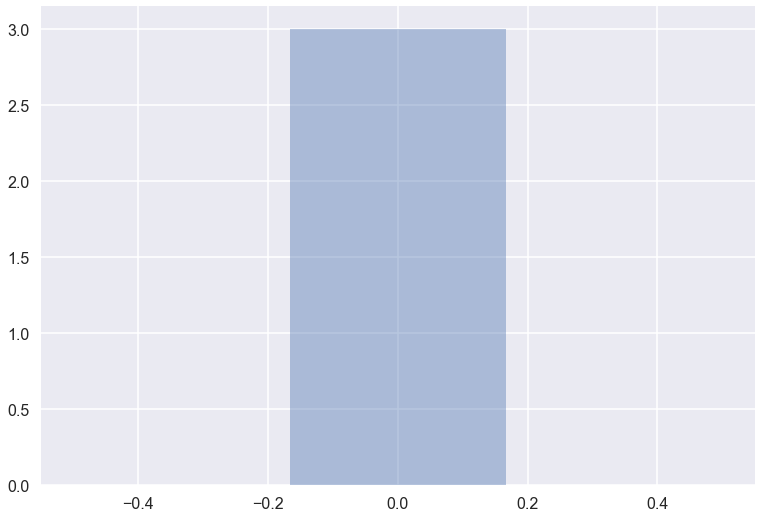

In [321]:
sns.distplot(np.zeros(10))